# Human Action Recognition with OpenVINO

This notebook demonstrates live human action recognition with OpenVINO. We use the [Action Recognition Models](https://docs.openvino.ai/2020.2/usergroup13.html) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo), specifically the [Encoder](https://docs.openvino.ai/2020.2/_models_intel_action_recognition_0001_encoder_description_action_recognition_0001_encoder.html) and [Decoder](https://docs.openvino.ai/2020.2/_models_intel_action_recognition_0001_decoder_description_action_recognition_0001_decoder.html). Both models create a sequence to sequence (`"seq2seq"`)<sup id="a1">[1](#f1)</sup> system to identify the  human activities for [Kinetics-400 dataset](https://deepmind.com/research/open-source/kinetics). The models use the Video Transformer approach with ResNet34 encoder<sup id="a2">[2](#f2)</sup>. We will see in this notebook how to create the following pipeline:

<img align='center' src="action_recognition_pipeline.jpeg" alt="drawing" width="1000"/>


At the bottom of this notebook, you will see live inference results from your webcam. You can also upload a video file.

NOTE: _To use the webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video in the final step._

<b id="f1">1</b> seq2seq: Deep learning models that take a sequence of items to the input and output. In this case, input: video frames, output: actions sequence. This `"seq2seq"` is composed of an encoder and a decoder. The encoder captures the `"context"` of the inputs to be analyzed by the decoder, and finally gets the human action and confidence.[$\hookleftarrow$](#a1)

<b id="f2">2</b>  [Video Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)#:~:text=A%20transformer%20is%20a%20deep,in%20computer%20vision%20(CV).), and [ResNet34](https://www.kaggle.com/pytorch/resnet34). [$\hookleftarrow$](#a2)



## Imports

In [4]:
import sys
import collections
import os
import time

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino import inference_engine as ie

from openvino.inference_engine import get_version

sys.path.append("../utils")
import notebook_utils as utils



## The models

### Download the models

We use `omz_downloader`, which is a command-line tool from the `openvino-dev` package. `omz_downloader` automatically creates a directory structure and downloads the selected model.

In this case you can use `"action-recognition-0001"` as a model name, and the system automatically downloads the two models `"action-recognition-0001-encoder"` and `"action-recognition-0001-decoder"`

If you want to download another model (`"driver-action-recognition-adas-0002-encoder"` + `"driver-action-recognition-adas-0002-decoder"`, and `"i3d-rgb-tf"`) , please change the model name. Note: Using a model outside the list can require different pre- and post-processing. 

In [5]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "action-recognition-0001"
# selected precision (FP32, FP16, FP16-INT8)
precision = "FP16-INT8"

model_path = f"model/intel/{model_name}/{model_name}/{precision}/{model_name}.xml"
model_weights_path = f"model/intel/{model_name}/{model_name}/{precision}/{model_name}.bin"

if not os.path.exists(model_path):
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--precision {precision} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command
    

################|| Downloading action-recognition-0001-decoder ||################

========== Downloading model\intel\action-recognition-0001\action-recognition-0001-decoder\FP16-INT8\action-recognition-0001-decoder.xml
... 100%, 302 KB, 1140 KB/s, 0 seconds passed

========== Downloading model\intel\action-recognition-0001\action-recognition-0001-decoder\FP16-INT8\action-recognition-0001-decoder.bin
... 14%, 1024 KB, 2985 KB/s, 0 seconds passed
... 28%, 2048 KB, 5044 KB/s, 0 seconds passed
... 42%, 3072 KB, 6564 KB/s, 0 seconds passed
... 56%, 4096 KB, 8462 KB/s, 0 seconds passed
... 70%, 5120 KB, 9642 KB/s, 0 seconds passed
... 84%, 6144 KB, 11252 KB/s, 0 seconds passed
... 99%, 7168 KB, 12754 KB/s, 0 seconds passed
... 100%, 7233 KB, 12870 KB/s, 0 seconds passed

################|| Downloading action-recognition-0001-encoder ||################

========== Downloading model\intel\action-recognition-0001\action-recognition-0001-encoder\FP16-INT8\action-recognition-0001-encoder.xml
...

### Check the model path of your models

We will be able to work with the models locally. Please check that you can see your models in your local machine after your download process.

In [6]:
# Creating the proper path for architecture and weights model files.
model_path_decoder = f"model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"
model_weights_path_decoder = f"model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.bin"

model_path_encoder = f"model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
model_weights_path_encoder = f"model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.bin"

# Testing the location of *.bin and *.xml
files = os.listdir(f"model/intel/{model_name}/{model_name}-encoder/{precision}")
print(files)

['action-recognition-0001-encoder.bin', 'action-recognition-0001-encoder.xml']


### Load your labels

We are using [Kinetics-400 dataset](https://deepmind.com/research/open-source/kinetics), and also we are providing you with the text file embedded into this notebook.

In [7]:
# If you want to use another model, you should change the labels file
labels = "data/kinetics.txt"

if labels:
    with open(labels) as f:
        labels = [line.strip() for line in f]
else:
    labels = None
    
#print(labels[0], np.shape(labels))

### Load the models

We will load the two models for this particular architecture, Encoder and Decoder. Downloaded models are located in a fixed structure, indicating vendor, model name, and precision.

 1. Initialize inference engine (IECore)
 2. Read the network from *.bin and *.xml files (weights and architecture)
 3. Load the model on the "CPU."
 4. Get input and output names of nodes.

Only a few lines of code are required to run the model. Let's see it.

#### Model Initialization function

In [8]:
#Model initialization

# initialize inference engine
ie_core = ie.IECore()

def model_init(model, weights):
    # read the network and corresponding weights from file
    net = ie_core.read_network(model, weights)
    # load the model on the CPU (you can use GPU or MYRIAD as well)
    exec_net = ie_core.load_network(net, "CPU")
    # get input and output names of nodes
    input_key = list(exec_net.input_info)[0]
    output_keys = list(exec_net.outputs.keys())
    return input_key, output_keys, exec_net

#### Initialization for Decoder

In [9]:
#Encoder initialization 
input_key_en, output_keys_en, exec_net_en = model_init(model_path_encoder, model_weights_path_encoder)
#Decoder initialization 
input_key_de, output_keys_de, exec_net_de = model_init(model_path_decoder, model_weights_path_decoder)

# get input size - Encoder
height_en, width_en = exec_net_en.input_info[input_key_en].tensor_desc.dims[2:]
# get input size - Decoder
height_de = exec_net_de.input_info[input_key_de].tensor_desc.dims[2:]

### Help functions

We will use the next AI functions to run the architecture Encoder-Decoder of ResNet34

1. Preprocess the input image before running the Encoder model. (`center_crop` and `adaptative_resize`)
2. Decode top-3 probabilities into label names. (`decode_output`)

Also, we can see here the minimal configuration to display text over the live streaming or video for the main process.


In [28]:
def center_crop(frame):
    """Center crop squared the original frame"""
    img_h, img_w, _ = frame.shape
    min_dim = min(img_h, img_w)
    start_x = int((img_w - min_dim) /2.)
    start_y = int((img_h - min_dim) /2.)
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim, ...]

def adaptive_resize(frame, dst_size):
    """Adaptative resize of the cropped image to adjust to the input size model 224"""
    h, w, _ = frame.shape
    scale = dst_size / min(h, w)
    ow, oh = int(w * scale), int(h * scale)
    if ow == w and oh == h:
        return frame
    return cv2.resize(frame, (ow, oh))

def decode_output(probs, labels, top_k=None):
    """Decodes top probabilities into corresponding label names"""
    top_k = 3
    #top_ind = np.argsort(probs)[::-1][:top_k]
    top_ind = np.argsort(-1*probs)[:top_k]
    #print(top_ind)
    #print(top_ind.shape)
    out_label = np.array(labels)[top_ind.astype(int)]
    decoded_labels = [out_label[0][0], out_label[0][1], out_label[0][2]]
    top_probs = np.array(probs)[0][top_ind.astype(int)]
    decoded_top_probs = [top_probs[0][0], top_probs[0][1], top_probs[0][2]]
    #print(top_probs[0][0], top_probs[0][1], top_probs[0][2])
    return decoded_labels, decoded_top_probs

"""Configuration for displaying images with text"""
FONT_COLOR = (255, 255, 255)
FONT_STYLE = cv2.FONT_HERSHEY_DUPLEX
FONT_SIZE = 0.7
TEXT_VERTICAL_INTERVAL = 25
TEXT_LEFT_MARGIN = 15    
        

### AI funtions

Following this pipeline, 

<img align='center' src="action_recognition_pipeline.jpeg" alt="drawing" width="1000"/>


we will use the next functions to help us to:

1. Preprocess frame before running the Encoder. (`preprocessing`)
2. Encoder Inference per frame. (`encoder`)
3. Decoder inference per set of frames. (`decoder`)
4. Normalize the Decoder output to get confidence values per action recognition label. (`softmax`)

Also, we can see here the minimal configuration to display text over the live streaming or video for the main process.

In [11]:
def preprocessing(frame, size):
    """Preparing frame before Encoder"""
    # Adaptative resize
    preprocessed = adaptive_resize(frame, size)
    # Center_crop                
    preprocessed = center_crop(preprocessed)
    # Transpose frame HWC -> CHW
    preprocessed = preprocessed.transpose((2, 0, 1))  # HWC -> CHW
    return preprocessed

def encoder(preprocessed, exec_net_en, input_key_en, encoder_output):
    """Encoder Inference per frame"""
    # get results on action-recognition-0001-encoder model
    infer_result_encoder = exec_net_en.infer(inputs={input_key_en: preprocessed})
    encoder_result = infer_result_encoder[output_keys_en[0]]
    encoder_output.append(encoder_result)
    return encoder_output

def decoder(encoder_output, exec_net_de, input_key_de):
    """Decoder inference per set of frames"""
    # Concatenate sample_duration frames in just one array
    decoder_input = np.concatenate(encoder_output, axis=0)
    # Organize input shape vector to the Decoder (shape: [1x16x512]]
    decoder_input = decoder_input.transpose((2, 0, 1, 3))
    decoder_input = np.squeeze(decoder_input, axis=3)

    # get results on action-recognition-0001-decoder model
    logits = exec_net_de.infer(inputs={input_key_de: decoder_input})
    result_de = logits[output_keys_de[0]]
    # Normalize logits to get confidence values along specified axis
    probs = softmax(result_de - np.max(result_de))
    # Decodes top probabilities into corresponding label names
    decoded_labels, decoded_top_probs = decode_output(probs, labels, top_k=3)
    return decoded_labels, decoded_top_probs


def softmax(x, axis=None):
    """Normalizes logits to get confidence values along specified axis"""
    exp = np.exp(x)
    return exp / np.sum(exp, axis=axis)

### Main Processing Function

Run action recognition function will run in different operations, either a webcam or a video file. See the list of procedures below:

1. Create a video player to play with target fps (`utils.VideoPlayer`).
2. Prepare a set of frames to be encoded-decoded.
3. Run AI functions
4. Visualize the results.

In [29]:
def run_action(source=0, flip=False, use_popup=False, skip_first_frames=0, sample_duration=16, size=224):
    """create video player to play with target fps"""
    player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
    # start capturing
    player.start()
    

    try:
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        
        processing_times = collections.deque()
        frames = []
        video_frames = []
        encoder_output = []
        decoded_labels = [0, 0, 0]
        decoded_top_probs = [0, 0, 0]
        while True:
            
            encoder_output = []
            # loop over the number of required sample frames
            """Prepare a set of frames to be enconded-decoded"""
            for i in range(0, sample_duration):
                # read a frame from the video stream
                frame = player.next()
                frames.append(frame)
                
                if frame is None:
                    print("Source ended")
                    break
                scale = 1280 / max(frame.shape)
                
                # Adaptative resize for visualization
                if scale < 1:
                    frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
                
                """Preprocess frame before Encoder"""
                preprocessed = preprocessing(frame, size)
                                
                # measure processing time
                start_time = time.time()
                
                """Encoder Inference per frame"""
                encoder_output = encoder(preprocessed, exec_net_en, input_key_en, encoder_output)
                
                """Decoder inference per set of frames"""
                # wait for sample duration to work with decoder model
                if len(encoder_output) == sample_duration:
                    decoded_labels, decoded_top_probs = decoder(encoder_output, exec_net_de, input_key_de)
                                        
                """ Inference has finished ... Let's to display results"""
                stop_time = time.time()
                
                # calculate processing time
                processing_times.append(stop_time - start_time)
                # create a text template to show inference results over video
                text_template = '{label},{conf:.2f}%,{Time:.1f}ms,{fps:.1f}FPS'
                # use processing times from last 200 frames
                if len(processing_times) > 200:
                    processing_times.popleft()
                    
                _, f_width = frame.shape[:2]
                # mean processing time [ms]
                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time

                """ Visualize the results"""
                for i in range(0, 3):
                    display_text = text_template.format(label=decoded_labels[i], conf=decoded_top_probs[i] * 100, Time=processing_time, fps=fps)
                    text_loc = (TEXT_LEFT_MARGIN, TEXT_VERTICAL_INTERVAL * (i + 1))
                    cv2.putText(frame, display_text, text_loc, FONT_STYLE, FONT_SIZE, FONT_COLOR)
                
                # use this workaround if there is flickering
                if use_popup:
                    cv2.imshow(title, frame)
                    key = cv2.waitKey(1)
                    # escape = 27
                    if key == 27:
                        break
                else:
                    # encode numpy array to jpg
                    _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                    # create IPython image
                    i = display.Image(data=encoded_img)
                    # display the image in this notebook
                    display.clear_output(wait=True)
                    display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)

    # stop capturing
    player.stop()
    if use_popup:
        cv2.destroyAllWindows()


### Run Action Recognition using your webcam

> NOTE: _To use the webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video in the final step._

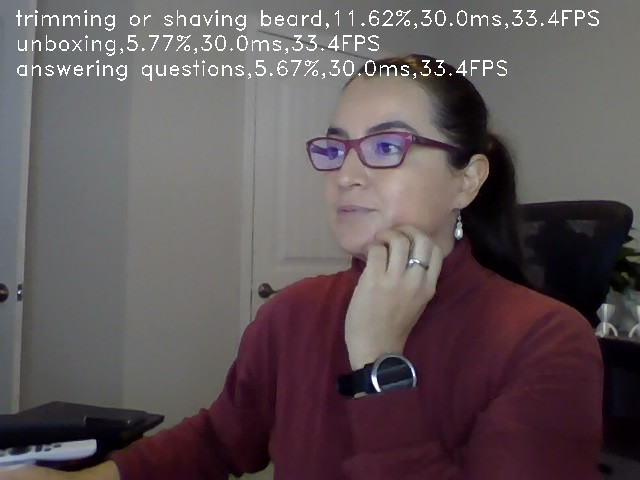

Interrupted


In [30]:
run_action(source=0, flip=False, use_popup=False, skip_first_frames=0, sample_duration=16, size=224)

### Run Action Recognition on a Video File

If you don't have a webcam, you can still run this demo with a video file. Any format supported by OpenCV will work (see: https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html). You can skip first N frames to fast forward video.

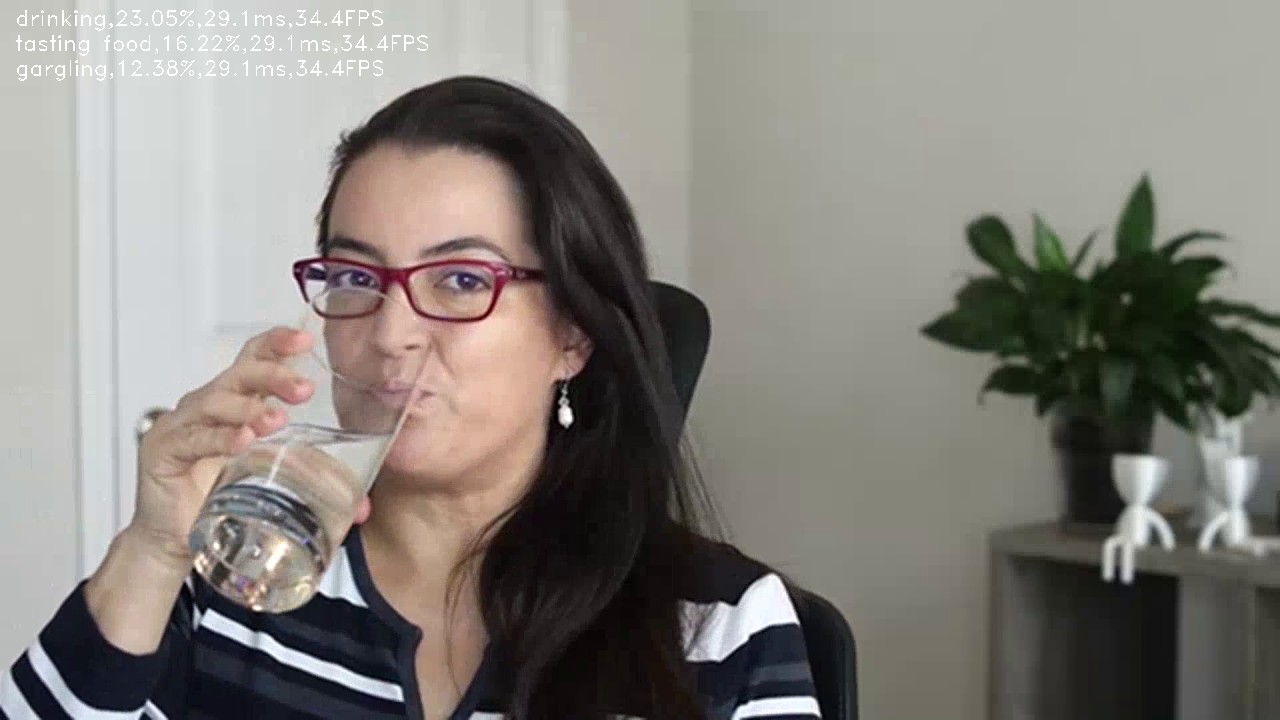

Interrupted


In [ ]:
video_file = "C:/Intel/notebooks/openvino_notebooks/notebooks/501-action-webcam/video/paula.mp4"
#"https://github.com/intel-iot-devkit/sample-videos/raw/master/head-pose-face-detection-female.mp4?raw=true"
#"https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4?raw=true"

run_action(video_file, flip=False, use_popup=False, skip_first_frames=500)